# Evaluate pressure rise using festim

Before starting to explore a potential parameter space, the experimental setup parameters must be set:

In [1]:
# sample diameter
test_sample_diameter = 20e-03 # in m

# sample thickenss
test_sample_thickness = 1e-03 # in m

# downstream pipe diameter
test_downstream_pipe_diameter = 5e-03 # in m

# downstream pipe length
test_downstream_pipe_length = 2 # in m

For instance, taking a single case where the sample temperature is 700K and the upstream pressure is 1e5 Pa:

In [2]:
from festim_scripts import festim_model_standard

temperature = 700  # K
festim_model_standard(
    sample_thickness=test_sample_thickness,
    T=temperature,
    pressure=1e5,
    foldername="results/",
    regime="diff",
    atol=1e8,
    final_time=5000,
)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        5.0e+03 s    Elapsed time so far: 1.2 s


With the simulation finished, the surface flux of hydrogen at the downstream side can be obtained and plotted against time:

Time to steady-state: 4039.67 s


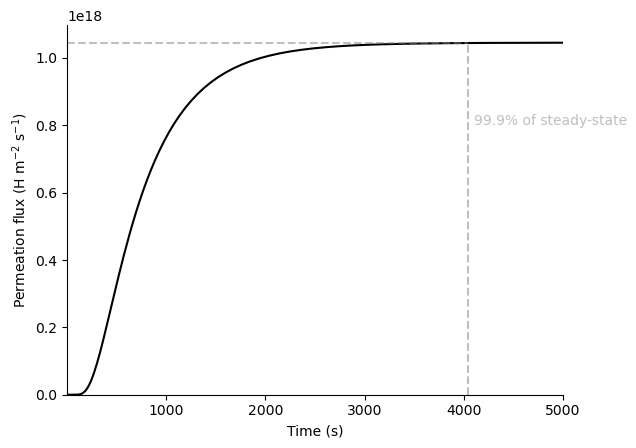

In [3]:
import matplotlib.pyplot as plt
import numpy as np

run_data = np.genfromtxt(
    f"results/permeation_standard.csv",
    delimiter=",",
    names=True,
)
t = run_data["ts"]
surface_flux = run_data["solute_flux_surface_2_H_m2_s1"] * -1

time_to_steady_ind = np.where(surface_flux > 0.999 * surface_flux[-1])[0][0]
time_to_steady = t[time_to_steady_ind]

print(f"Time to steady-state: {time_to_steady:.2f} s")

plt.figure()
plt.plot(t, surface_flux, color="black")
plt.vlines(time_to_steady, 0, surface_flux[time_to_steady_ind], color="grey", linestyle="dashed", alpha=0.5)
plt.hlines(surface_flux[time_to_steady_ind], 0, time_to_steady, color="grey", linestyle="dashed", alpha=0.5)
plt.annotate("99.9% of steady-state", [4100, 0.8e18], ha="left", color="grey", alpha=0.5)
plt.xlabel(r"Time (s)")
plt.ylabel(r"Permeation flux (H m$^{-2}$ s$^{-1}$)")
plt.xlim(t[0], t[-1])
plt.ylim(bottom=0)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

From this is can be evaulated it took just over 4000s for the surface flux to reach 99.9% of the steady-state value. 

Furthermore, with this result and the downstream parameters, the subsequent pressure rise in the downstream, $P_{\mathrm{down}}$, can be evaluated 

$$J_\mathrm{permeation}(t) = \frac{dP_{\mathrm{down}}}{dt} \frac{V}{A R_g T}$$

where $A$ is the cross sectional area of the sample, $V$ is the downstream volume, $R_g$ is the gas constant, and $T$ is the temperature.


This can be subsequently plotted:

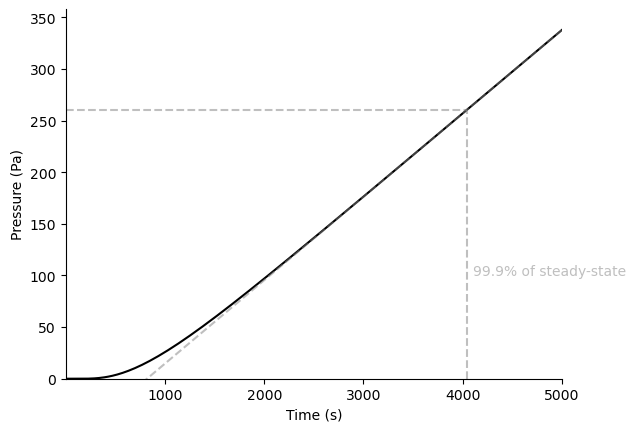

In [4]:
from festim_scripts import pressure_from_flux
from scipy.interpolate import UnivariateSpline

P_down = pressure_from_flux(
    flux=surface_flux,
    t=t,
    T=700,
    sample_diameter=test_sample_diameter,
    downstream_pipe_diameter=test_downstream_pipe_diameter,
    downstream_pipe_length=test_downstream_pipe_length
)

# Create a spline for interpolation
spline = UnivariateSpline(t, P_down, s=0)
# Point of interest
y_tangent = spline(time_to_steady)
# Derivative at the tangent point
slope = spline.derivative()(time_to_steady)
# Equation of the tangent line: y = mx + c
tangent_line = slope * (t - time_to_steady) + y_tangent

plt.figure()
plt.plot(t, P_down, color="black")
plt.plot(t, tangent_line, color="grey", linestyle="dashed", alpha=0.5)
plt.vlines(x=time_to_steady, ymin=0, ymax=y_tangent, color="grey", linestyle="dashed", alpha=0.5)
plt.hlines(y=y_tangent, xmin=0, xmax=time_to_steady, color="grey", linestyle="dashed", alpha=0.5)
plt.annotate("99.9% of steady-state", [4100, 100], ha="left", color="grey", alpha=0.5)
plt.xlabel(r"Time (s)")
plt.ylabel(r"Pressure (Pa)")
plt.xlim(t[0], t[-1])
plt.ylim(bottom=0)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

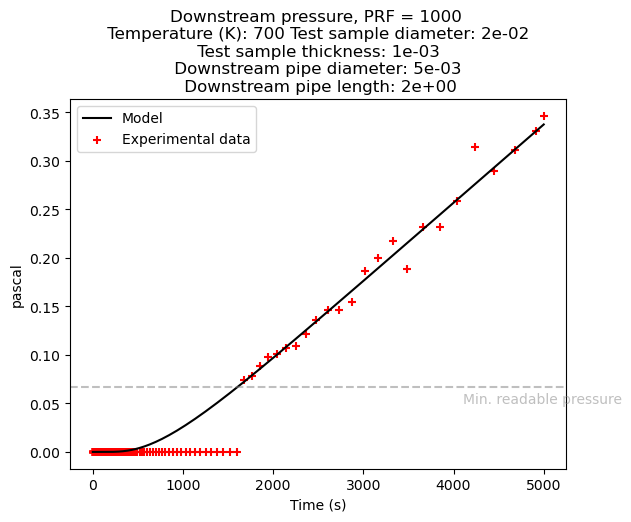

In [16]:
import pint

ureg = pint.UnitRegistry()
ureg.setup_matplotlib()
gauge_full_scale = 1 * ureg.torr
minimum_readable_pressure = 0.05 * ureg.percent * gauge_full_scale

prf = 1000
# generate dummy data
P_down_noise = np.random.normal(0, 0.05, t.shape)
P_down_exp = (1/prf * P_down * (1 + P_down_noise)) * ureg.Pa

# set P_down_exp to zero if below minimum readable pressure
P_down_exp[P_down_exp < minimum_readable_pressure] = 0 * ureg.Pa

# set P_down_exp to gauge_full_scale if above gauge_full_scale
P_down_exp[P_down_exp > gauge_full_scale] = gauge_full_scale

plt.plot(t, P_down/prf * ureg.Pa, color="black", label="Model")

plt.scatter(t, P_down_exp, color="red", label="Experimental data", marker="+")


plt.xlabel("Time (s)")
plt.axhline(minimum_readable_pressure, color="grey", linestyle="dashed", alpha=0.5)
# plt.axhline(gauge_full_scale, color="grey", linestyle="dashed", alpha=0.5)

plt.annotate("Min. readable pressure", [4100, 0.05], ha="left", color="grey", alpha=0.5)
plt.annotate(f"Max. readable pressure \n {gauge_full_scale:~.1f}", [4100, gauge_full_scale * 1.02], ha="left", color="grey", alpha=0.5)

plt.title(f"Downstream pressure, PRF = {prf} \n Temperature (K): {temperature} Test sample diameter: {test_sample_diameter:.0e} \n Test sample thickness: {test_sample_thickness:.0e} \n Downstream pipe diameter: {test_downstream_pipe_diameter:.0e} \n Downstream pipe length: {test_downstream_pipe_length:.0e}")
plt.legend()